# **Northeastern SMILE Lab - Recognizing Faces in the Wild**

by Charles Solorio, Ezra

## **Description**

Do you have your father’s nose?

Blood relatives often share facial features. Now researchers at Northeastern University want to improve their algorithm for facial image classification to bridge the gap between research and other familial markers like DNA results. That will be your challenge in this new Kaggle competition.

An automatic kinship classifier has been in the works at Northeastern since 2010. Yet this technology remains largely unseen in practice for a couple of reasons:

1. Existing image databases for kinship recognition tasks aren't large enough to capture and reflect the true data distributions of the families of the world.

2. Many hidden factors affect familial facial relationships, so a more discriminant model is needed than the computer vision algorithms used most often for higher-level categorizations (e.g. facial recognition or object classification).

In this competition, you’ll help researchers build a more complex model by determining if two people are blood-related based solely on images of their faces. If you think you can get it "on the nose," this competition is for you.


### Evaluation

Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target. Not all pairs will be scored.

### Submission File
For each img_pair in the test set, you must predict a probability for the is_related variable. The column img_pair describes the pair of images, i.e., abcdef-ghijkl means the pair of images abcdef.jpg and ghijkl.jpg.

The file should contain a header and have the following format:


    img_pair,is_related
    X3Nk6Hfe5x-qcZrTXsfde,0.0
    X3Nk6Hfe5x-LD0pWDM8w_,0.0
    X3Nk6Hfe5x-PHwuDtHyGp,0.0
    X3Nk6Hfe5x-LO6lN_U4ot,0.0


etc.

## **Dataset Description**


### Data Overview

In this competition, you will predict if two people share a kinship relationship or not based on their facial images. The data is provided by Families In the Wild (FIW), the largest and most comprehensive image database for automatic kinship recognition.

FIW's dataset is obtained from publicly available images from celebrities. For more information about their labeling process, please visit their database page.


### File descriptions

- train-faces.zip - the training set is divided in Families (F0123), then individuals (MIDx). Images in the same MIDx folder belong to the same person. Images in the same F0123 folder belong to the same family.

- train.csv - training labels. Remember, not every individual in a family shares a kinship relationship. For example, a mother and father are kin to their children, but not to each other.

- test-faces.zip - the test set contains face images of unknown individuals

- sample_submission.csv - a sample submission file in the correct format. The column img_pair describes the pair of images, i.e., abcdef-ghijkl means the pair of images abcdef.jpg and ghijkl.jpg. 


Your goal is to predict if each pair of images in test-faces are related or not, where 1 means related and 0 means unrelated.

# **Recognizing Families In the Wild (RFIW): Data**


Competition is based on the Families In the Wild (FIW) dataset. See project page for more information, https://web.northeastern.edu/smilelab/fiw/.

Contents are as follows:
* **test-public-face**
    * Directories of faces to train (and validate) with. Faces are split by family ID, then into respective family-member ID.
* **test-public-lists**
    * Pair lists made up of 3 columns (i.e., pair per row):
        1. label (i.e., 1/0 aka KIN/ NON-KIN)
        2. path to face for subject 1
        3. path to face for subject 2
* **test-private-face**
    * Faces for testing (i.e., blind, so faces are all in single folder named face[0-N] where N is the number of test faces.)
* **test-private-lists**
    *  Pair lists made up of 2 columns: 
        1. image name for subject 1 
        2. image name for subject 2. 
* **test-private-labels**
    *  Ground truth for test set, using same name scheme and order as respective lists.   

### Packages

In [2]:
# MISC
import warnings; warnings.simplefilter('ignore') # Ignore package warning messages
import logging; logger = logging.getLogger(); logger.setLevel(logging.CRITICAL) # Supress default INFO logging
import os
import glob
from collections import defaultdict
from random import choice

# Math / Arithmetic
import numpy as np
import pandas as pd
from scipy.spatial import distance

# Visualization
from imageio import imread # Read images
from skimage.transform import resize
from tqdm import tqdm
import cv2

%matplotlib inline
import matplotlib.pyplot as plt

# AI
from keras.models import load_model
from keras_applications.imagenet_utils import _obtain_input_shape
from keras_vggface.vggface import VGGFace

### Loading Train relationships and Test relationships 

In [3]:
train_df = pd.read_csv("./train_relationships.csv")
test_df = pd.read_csv("./sample_submission.csv")

In [4]:
train_df.head()

,p1,p2
0,F0002/MID1,F0002/MID3
1,F0002/MID2,F0002/MID3
2,F0005/MID1,F0005/MID2
3,F0005/MID3,F0005/MID2
4,F0009/MID1,F0009/MID4


In [5]:
test_df.head()

,img_pair,is_related
0,face05508.jpg-face01210.jpg,0
1,face05750.jpg-face00898.jpg,0
2,face05820.jpg-face03938.jpg,0
3,face02104.jpg-face01172.jpg,0
4,face02428.jpg-face05611.jpg,0


#### Create a list of all photos to display examples

In [6]:
# Keeps all photos path in a dictionary
allPhotos = defaultdict(list)
for family in glob.glob("./train/*"):
    for mem in glob.glob(family+'/*'):
        for photo in glob.glob(mem+'/*'):
            allPhotos[mem].append(photo)

# List of all members with valid photo
ppl = list(allPhotos.keys())
len(ppl)

2316

In [7]:
allPhotos

defaultdict(list,
            {'./train/F0197/MID3': ['./train/F0197/MID3/P02113_face5.jpg',
              './train/F0197/MID3/P02117_face3.jpg',
              './train/F0197/MID3/P02119_face5.jpg',
              './train/F0197/MID3/P02114_face1.jpg',
              './train/F0197/MID3/P02116_face4.jpg',
              './train/F0197/MID3/P02115_face3.jpg'],
             './train/F0197/MID4': ['./train/F0197/MID4/P02118_face4.jpg',
              './train/F0197/MID4/P02119_face6.jpg',
              './train/F0197/MID4/P02114_face6.jpg',
              './train/F0197/MID4/P02116_face6.jpg',
              './train/F0197/MID4/P02120_face3.jpg',
              './train/F0197/MID4/P02115_face6.jpg',
              './train/F0197/MID4/P02117_face1.jpg',
              './train/F0197/MID4/P02113_face2.jpg'],
             './train/F0197/MID6': ['./train/F0197/MID6/P02119_face4.jpg',
              './train/F0197/MID6/P02116_face2.jpg',
              './train/F0197/MID6/P02117_face4.jpg',
             

### Duplicate DataFrame for a complete path reference of train data

In [8]:
data = train_df.copy()
data.p1 = data.p1.apply( lambda x: './train/' + x )
data.p2 = data.p2.apply( lambda x: './train/' + x )
print(data.shape)
data.head()

(3598, 2)


,p1,p2
0,./train/F0002/MID1,./train/F0002/MID3
1,./train/F0002/MID2,./train/F0002/MID3
2,./train/F0005/MID1,./train/F0005/MID2
3,./train/F0005/MID3,./train/F0005/MID2
4,./train/F0009/MID1,./train/F0009/MID4


#### Choose random samples for display related people

In [9]:
SAMPLE = 4
rows = data.sample(SAMPLE)
rows

,p1,p2
120,./train/F0038/MID1,./train/F0038/MID5
1716,./train/F0494/MID3,./train/F0494/MID4
3448,./train/F0969/MID1,./train/F0969/MID3
1484,./train/F0423/MID4,./train/F0423/MID3


#### Plot example images

RELATED PEOPLE (relationship left-right): 


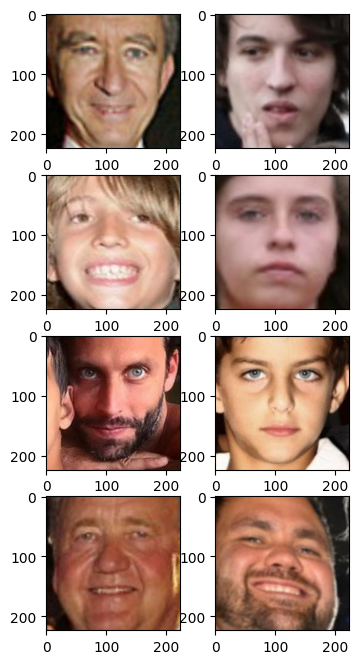

In [45]:
f, ax = plt.subplots(SAMPLE, 2, figsize=(4, 8))
print("RELATED PEOPLE (relationship left-right): ")

for i in range(len(rows)):
    # Take related persons path
    p1 = rows.iloc[i]["p1"]
    p2 = rows.iloc[i]["p2"]

    # print(f"Available images for p1 ({len(allPhotos[p1])}): " + str(allPhotos[p1]))
    # print(f"Available images for p2 ({len(allPhotos[p2])}): " + str(allPhotos[p2]))
    # print(img1)
    # print(img2)

    # Take random image from all availables of each person
    img1 = choice(allPhotos[p1])
    img2 = choice(allPhotos[p2])

    # Convert image to RGB format
    rgb1 = cv2.cvtColor(cv2.imread(img1), cv2.COLOR_BGR2RGB)
    rgb2 = cv2.cvtColor(cv2.imread(img2), cv2.COLOR_BGR2RGB)

    # Plot
    ax[i][0].imshow(rgb1, cmap = plt.cm.Spectral)
    ax[i][1].imshow(rgb2, cmap = plt.cm.Spectral)


### Convolution Features with VGGFace Model

In [11]:
vgg_features = VGGFace(include_top=False, input_shape=(160, 160, 3), pooling='avg')
model = vgg_features
# model.__dir__()

In [12]:
model.summary()

Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 160, 160, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 160, 160, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 80, 80, 64)        0         
                                                                 
 conv2_1 (Conv2D)            (None, 80, 80, 128)       73856     
                                                                 
 conv2_2 (Conv2D)            (None, 80, 80, 128)       147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 40, 40, 128)     

### Useful funcitons for easier training

In [13]:
"""It subtracts the average and normalizes the range of the pixel values of input images. It makes training a lot easier."""
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0 / np.sqrt(size))
    y = (x - mean) / std_adj

    return y


"""It may be defined as the normalization technique that modifies the dataset values in a way that in each row the sum of the squares will always be up to 1. It is also called least squares."""
def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))

    return output


"""Preprocess images aligning and resizing"""
def preprocess_images(paths, image_size=160):
    preprocessed_images = []
    for path in paths:
        img = imread(path)
        resized_image = resize(img, (image_size, image_size), mode='reflect')
        preprocessed_images.append(resized_image)
            
    return np.array(preprocessed_images)

### Load test images

In [14]:
test_images = os.listdir("./test/")
print(test_images[0])
len(test_images)

face05978.jpg


6282

### Creates test paths

In [15]:
test_paths = [os.path.join("./test/", f) for f in test_images]
test_paths[0]

'./test/face05978.jpg'

### Create a low-dimensional learned continuous vector representation of discrete variables into which you can translate high-dimensional vectors  (Predictions with VGG Model). 

In [16]:
tmp = []
batch_size = 8

for start in tqdm(range(0, len(test_paths), batch_size)):
    preprocessed_images = prewhiten(preprocess_images(test_paths[start:start+batch_size]))
    tmp.append(model.predict_on_batch(preprocessed_images))

test_embs = l2_normalize(np.concatenate(tmp))

  0%|          | 0/786 [00:00<?, ?it/s]2024-10-13 11:45:24.391636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [8,160,160,3]
	 [[{{node Placeholder/_0}}]]
  0%|          | 1/786 [00:01<14:52,  1.14s/it]2024-10-13 11:45:25.507232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [8,160,160,3]
	 [[{{node Placeholder/_0}}]]
  0%|          | 2/786 [00:02<18:22,  1.41s/it]2024-10-13 11:45:27.274243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error an

In [17]:
test_embs.shape

(6282, 512)

### Create a dictionary of images by id

In [20]:
img_dict = dict()
for idx, img in enumerate(test_images):
    img_dict[img] = idx
img_dict

{'face05978.jpg': 0,
 'face01921.jpg': 1,
 'face02826.jpg': 2,
 'face02648.jpg': 3,
 'face00303.jpg': 4,
 'face05575.jpg': 5,
 'face02580.jpg': 6,
 'face03215.jpg': 7,
 'face02440.jpg': 8,
 'face00368.jpg': 9,
 'face05739.jpg': 10,
 'face04955.jpg': 11,
 'face00065.jpg': 12,
 'face01484.jpg': 13,
 'face02291.jpg': 14,
 'face01205.jpg': 15,
 'face02931.jpg': 16,
 'face02014.jpg': 17,
 'face01517.jpg': 18,
 'face01733.jpg': 19,
 'face00443.jpg': 20,
 'face00591.jpg': 21,
 'face00778.jpg': 22,
 'face02226.jpg': 23,
 'face05800.jpg': 24,
 'face03295.jpg': 25,
 'face06093.jpg': 26,
 'face02338.jpg': 27,
 'face00205.jpg': 28,
 'face04526.jpg': 29,
 'face03969.jpg': 30,
 'face00582.jpg': 31,
 'face05888.jpg': 32,
 'face03853.jpg': 33,
 'face02995.jpg': 34,
 'face04537.jpg': 35,
 'face03228.jpg': 36,
 'face00535.jpg': 37,
 'face01428.jpg': 38,
 'face02000.jpg': 39,
 'face06064.jpg': 40,
 'face06026.jpg': 41,
 'face04899.jpg': 42,
 'face05371.jpg': 43,
 'face01970.jpg': 44,
 'face00984.jpg': 45

#### Create a new column for distance

In [19]:
test_df["distance"] = 0
test_df.head()

,img_pair,is_related,distance
0,face05508.jpg-face01210.jpg,0,0
1,face05750.jpg-face00898.jpg,0,0
2,face05820.jpg-face03938.jpg,0,0
3,face02104.jpg-face01172.jpg,0,0
4,face02428.jpg-face05611.jpg,0,0


#### Get distance bwtween image pairs

In [21]:
for idx, row in tqdm(test_df.iterrows(), total=len(test_df)):
    imgs = [test_embs[img_dict[img]] for img in row.img_pair.split("-")]
    test_df.loc[idx, "distance"] = distance.euclidean(*imgs)

100%|██████████| 5310/5310 [00:01<00:00, 5172.73it/s]


In [22]:
test_df.head()

,img_pair,is_related,distance
0,face05508.jpg-face01210.jpg,0,1.102726
1,face05750.jpg-face00898.jpg,0,1.094178
2,face05820.jpg-face03938.jpg,0,1.049487
3,face02104.jpg-face01172.jpg,0,0.922057
4,face02428.jpg-face05611.jpg,0,0.977653


#### Sum of all distances

In [23]:
all_distances = test_df.distance.values
sum_dist = np.sum(all_distances)
sum_dist

5313.954209685326

### Get probabilities

In [24]:
probs = []
for dist in tqdm(all_distances):
    prob = np.sum(all_distances[np.where(all_distances <= dist)[0]]) / sum_dist
    probs.append(1 - prob)

100%|██████████| 5310/5310 [00:00<00:00, 34932.36it/s]


### Change is_related to propability from VGGFace model

In [26]:
sub_df = pd.read_csv("./sample_submission.csv")
sub_df.is_related = probs
sub_df.to_csv("submission.csv", index=False)

In [27]:
sub_df.head()

,img_pair,is_related
0,face05508.jpg-face01210.jpg,0.184423
1,face05750.jpg-face00898.jpg,0.217081
2,face05820.jpg-face03938.jpg,0.413311
3,face02104.jpg-face01172.jpg,0.825396
4,face02428.jpg-face05611.jpg,0.679119


In [28]:
sub_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5310 entries, 0 to 5309
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   img_pair    5310 non-null   object 
 1   is_related  5310 non-null   float64
dtypes: float64(1), object(1)
memory usage: 83.1+ KB


In [29]:
sub_df.describe()

,is_related
count,5310.000000
mean,0.529432
std,0.291430
min,0.000000
25%,0.279730
50%,0.541670
75%,0.786456
max,0.999963


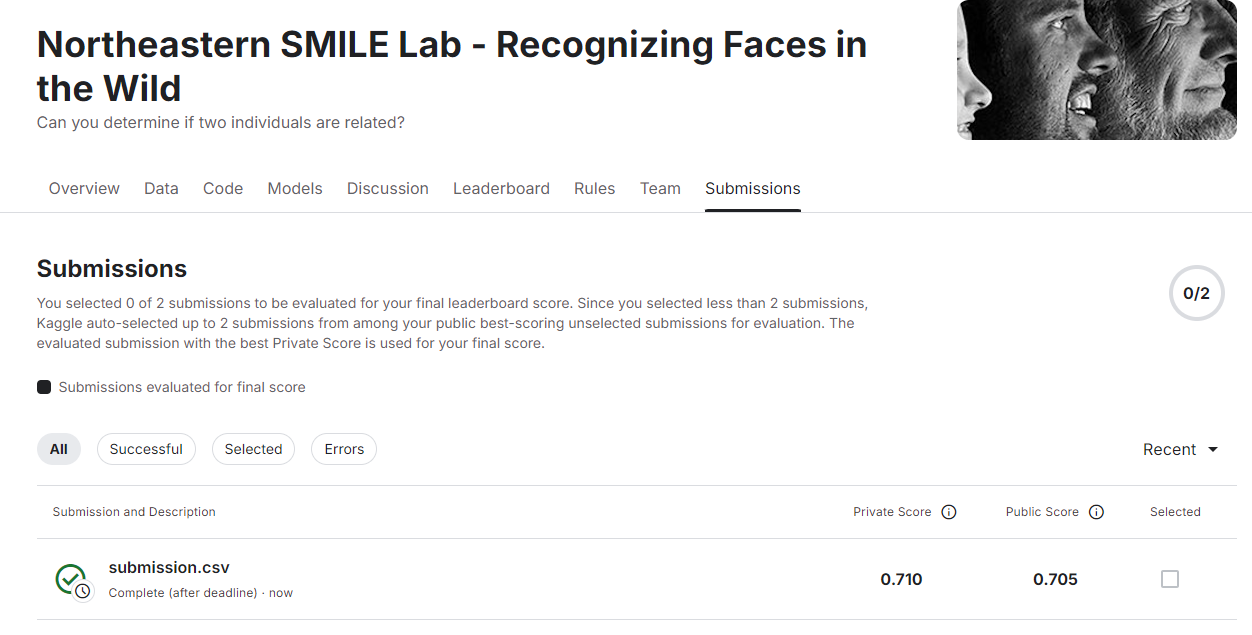

## Some examples (get the portion of samples that has a very good relationship prediction)

#### Make a test image paths dictionary

In [46]:
examples = sub_df.copy()

In [48]:
# Keeps all photos path in a list
test_photos = []
for photo in glob.glob("./test/*"):
    test_photos.append(photo)

# List of all members with valid photo
len(test_photos)

6282

### Get related examples

In [47]:
related_examples = examples.loc[(examples['is_related'] >= 0.75)]
related_examples.head()

,img_pair,is_related
3,face02104.jpg-face01172.jpg,0.825396
7,face03697.jpg-face01892.jpg,0.961703
12,face03140.jpg-face05223.jpg,0.796555
15,face02240.jpg-face02336.jpg,0.878166
16,face02131.jpg-face05209.jpg,0.979154


In [35]:
RELATED_SAMPLE = 8
related = related_examples.sample(RELATED_SAMPLE)
related

,img_pair,is_related
2593,face04080.jpg-face02417.jpg,0.773751
4516,face01990.jpg-face03800.jpg,0.860961
2961,face01539.jpg-face01633.jpg,0.851074
4303,face01218.jpg-face06012.jpg,0.812863
3331,face00800.jpg-face03328.jpg,0.887856
1383,face03286.jpg-face00205.jpg,0.969515
4408,face02392.jpg-face02084.jpg,0.948231
3330,face05862.jpg-face05475.jpg,0.788091


RELATED PEOPLE (relationship left-right): 


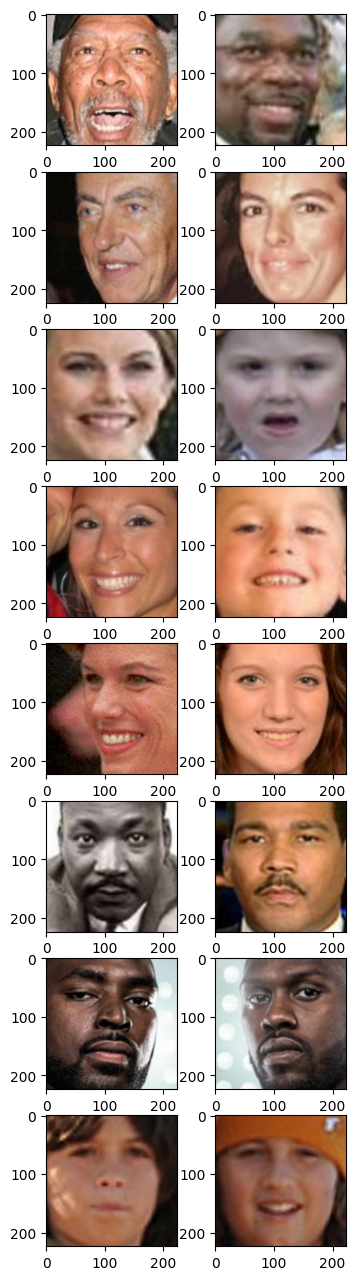

In [44]:
f, ax = plt.subplots(RELATED_SAMPLE, 2, figsize=(4, 16))
print("RELATED PEOPLE (relationship left-right): ")

for i in range(len(related)):
    # Take related persons path
    images = related.iloc[i]["img_pair"].split("-")
    p1 = "./test/" + images[0]
    p2 = "./test/" + images[1]

    # Convert image to RGB format
    rgb1 = cv2.cvtColor(cv2.imread(p1), cv2.COLOR_BGR2RGB)
    rgb2 = cv2.cvtColor(cv2.imread(p2), cv2.COLOR_BGR2RGB)

    # Plot
    ax[i][0].imshow(rgb1, cmap = plt.cm.Spectral)
    ax[i][1].imshow(rgb2, cmap = plt.cm.Spectral)

### Now lets see the non related persons

In [49]:
non_related_examples = examples.loc[(examples['is_related'] <= 0.25)]
non_related_examples.head()

,img_pair,is_related
0,face05508.jpg-face01210.jpg,0.184423
1,face05750.jpg-face00898.jpg,0.217081
6,face04262.jpg-face00555.jpg,0.080753
14,face03012.jpg-face04103.jpg,0.032209
19,face02836.jpg-face01540.jpg,0.130762


In [50]:
NON_RELATED_SAMPLE = 8
non_related = non_related_examples.sample(NON_RELATED_SAMPLE)
non_related

,img_pair,is_related
1834,face05056.jpg-face00167.jpg,0.248481
2485,face04027.jpg-face01647.jpg,0.087577
3288,face03980.jpg-face04788.jpg,0.238858
3286,face00723.jpg-face00548.jpg,0.104368
514,face00200.jpg-face04208.jpg,0.082247
3632,face04292.jpg-face04920.jpg,0.165709
582,face04169.jpg-face04012.jpg,0.196647
1,face05750.jpg-face00898.jpg,0.217081


NON RELATED PEOPLE (relationship left-right): 


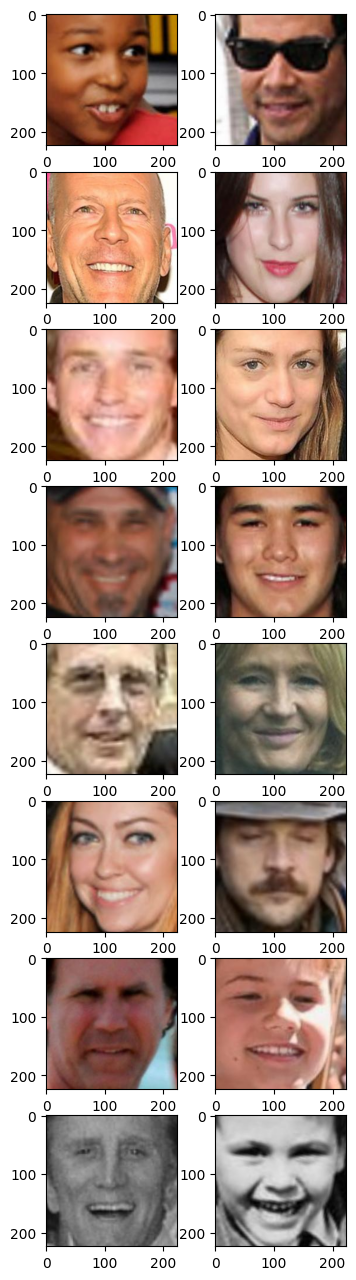

In [51]:
f, ax = plt.subplots(NON_RELATED_SAMPLE, 2, figsize=(4, 16))
print("NON RELATED PEOPLE (relationship left-right): ")

for i in range(len(non_related)):
    # Take related persons path
    images = non_related.iloc[i]["img_pair"].split("-")
    p1 = "./test/" + images[0]
    p2 = "./test/" + images[1]

    # Convert image to RGB format
    rgb1 = cv2.cvtColor(cv2.imread(p1), cv2.COLOR_BGR2RGB)
    rgb2 = cv2.cvtColor(cv2.imread(p2), cv2.COLOR_BGR2RGB)

    # Plot
    ax[i][0].imshow(rgb1, cmap = plt.cm.Spectral)
    ax[i][1].imshow(rgb2, cmap = plt.cm.Spectral)